In [2]:
!pip install nilearn

     |████████████████████████████████| 2.5MB 4.8MB/s 


In [0]:
## First part: preprocess
# Import packages
import os
from nilearn import image
import torch
import numpy as np
from scipy.ndimage import zoom
from google.colab import drive

#from sklearn.utils import shuffle

In [0]:
def get_namelist(rootpath, subpath):
  # Go to corresponding directory
  datapath=os.path.join(rootpath,subpath)
  os.chdir(datapath)

  # Get text files
  textfileList = []
  for file in os.listdir():
      if file.endswith(".txt"):
          textfileList.append(file)
  print("File name list with extensions:")
  print(textfileList)

  # Get nii file names
  nameList = []
  for file in textfileList:
      nameList.append(file.split('.')[0][:-4])
  print("File name list without extensions:")
  print(nameList)

  return nameList

In [0]:
def preprocess(nameList, datapath, minHeight=96, minLength=96):
  index = 0
  if not os.path.exists("processed"): # create directory to store processed data
    os.mkdir("processed")
  for file in nameList: # Import data
    if os.path.exists(file + '.nii'): # read either .nii or .nii.gz
        print("Processing:" , file + '.nii')
        img = image.smooth_img(os.path.join(datapath, file + '.nii'), fwhm=None) # no smooth
    elif os.path.exists(file + '.nii.gz'):
        print("Processing:", file + '.nii.gz')
        img = image.smooth_img(os.path.join(datapath, file + '.nii.gz'), fwhm=None) # no smooth
    else: # if not found, then pass
        continue

    img = img.get_fdata() # NiFTI to Numpy data type
    dim = img.shape
    # 4D to 3D #third dimension is slice number
    m, n = img.shape[:2]
    img = np.rollaxis(img, 3, 2).reshape(m, n, -1)

    # Down sampling to a same size, e.g., 96x96
    img = zoom(img, (minLength/img.shape[0], minHeight/img.shape[1], 1))

    # Normalize to 0-1
    v_min = img.min(axis=(0, 1), keepdims=True)
    v_max = img.max(axis=(0, 1), keepdims=True)
    img = (img - v_min)/(v_max - v_min)    


    img = np.moveaxis(img, -1, 0) #move the third dim to the first dim for running cnn which needs the first dim is the sample#
    img = np.reshape(img, (img.shape[0], 1, minLength, minHeight)) #convert 2D sample to 3D
    samples = img.shape[0]

    tensor = torch.from_numpy(img)
    torch.save(tensor, os.path.join('processed', file + '_processed.pt')) # save processed data into numpy format

    # Label
    data = open(os.path.join(datapath, file + '_man.txt'), 'r') # open label file
    temp = [] # temporary file to store label into a list 
    
    for line in data: # read lines in a text file
        numbers = (line.split(':')[1].replace('\n', '').split(' '))
        for i in range(len(numbers)): # convert string to list of int
            try:
                numbers[i] = int(numbers[i])
            except:
                numbers[i] = -1
                pass
        temp.append(numbers)
        # end convert
    data.close()
    # Store labels and save into numpy type
    label = np.zeros((dim[2] * dim[3],)) #1D, use ',' so that you can concatenate later (y=np.concatenate([y,label])), default: 0 means good slice; shape[2] is slice#, shape[3] is vol#
    for i in range(len(temp)): #for each vol
        for j in range(len(temp[i])): #for each slice in this vol
            if temp[i][j] != -1:
                label[dim[2] * i + temp[i][j]-1] = 1 #1 means bad slice, the slice index in the text file start from 1, but in python, index starts from 0, so minus 1.

    tensor = torch.from_numpy(label)         
    torch.save(tensor, os.path.join('processed', file + '_label.pt')) # save data label
    
    index = index + 1
    # end this file
  # end processing data 
  print("Done!")    

In [111]:
# Set path and mount
rootpath=r'/content/drive'
subpath=r'My Drive/HanaoLi/dtiqc/dataset'
drive.mount(rootpath)
# Preprocess and save processed file into processed folder
namelist = get_namelist(rootpath, subpath)
preprocess(nameList=namelist, datapath=os.path.join(rootpath,subpath))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File name list with extensions:
['1_man.txt', '2_man.txt', 'test_S11_man.txt', 'test_S7_man.txt']
File name list without extensions:
['1', '2', 'test_S11', 'test_S7']
Processing: 1.nii
Processing: 2.nii
Processing: test_S11.nii.gz
Processing: test_S7.nii.gz
Done!


In [0]:
## Second Part: Model
# Import packages
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torchvision import transforms

In [118]:
# Set rootpath and datapath
rootpath=r'/content/drive'
subpath=r'My Drive/HanaoLi/dtiqc/dataset/processed'
drive.mount(rootpath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Go to data directory
datapath=os.path.join(rootpath,subpath)
os.chdir(datapath)

In [120]:
# Select training and testing data
file_list = []
for file in os.listdir():
  if file.endswith("label.pt"):
    file_list.append(file.split('_label.pt')[0])

# Randomly select one as testing data, e.g, test_s7
test_list = file_list[3]
train_list = file_list[:3]
print(test_list)
print(train_list)

test_S7
['1', '2', 'test_S11']


In [0]:
# Load training data and labels
index = 0
for file in train_list:
  filename = file + '_processed.pt'
  labelname = file + '_label.pt'
  if index == 0:
    train_data = torch.load(filename)
    train_label = torch.load(labelname)
  else:
    temp_data = torch.load(filename)
    temp_label = torch.load(labelname)
    train_data = torch.cat([train_data, temp_data], dim=0)
    train_label = torch.cat([train_label, temp_label], dim=0)
  index = index + 1

In [0]:
# Make training data and label into Dataset Class
train_dataset = []
for i in range(len(train_data)):
  train_dataset.append([train_data[i], train_label[i]])

In [0]:
# Split between train and validation dataset
num_train = len(train_dataset)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(0.2 * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Dataloader Class
train_batch = 16
valid_batch = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=valid_batch, sampler=valid_sampler)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # VGG architecture
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 16, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv4 = nn.Conv2d(32, 32, 3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv6 = nn.Conv2d(64, 64, 3)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv8 = nn.Conv2d(128, 128, 3)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv9 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv10 = nn.Conv2d(256, 256, 3)
    self.bn5 = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(256 * 1, 64)
    self.fc2 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):

    x = self.conv1(x)
    x = self.pool(F.relu(self.bn1(self.conv2(x))))
    x = self.conv3(x)
    x = self.pool(F.relu(self.bn2(self.conv4(x))))
    x = self.conv5(x)
    x = self.pool(F.relu(self.bn3(self.conv6(x))))
    x = self.conv7(x)
    x = self.pool(F.relu(self.bn4(self.conv8(x))))
    x = self.conv9(x)
    x = self.pool(F.relu(self.bn5(self.conv10(x))))
    x = x.view(-1, 256*1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.sigmoid(x)
    x = torch.flatten(x)
    return x

In [0]:
# Initialize weight 
def init_weight(m):
    classname = m.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.001)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.001)
        nn.init.normal_(m.bias.data, 0.0)

In [0]:
# Create model using gpu
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.apply(init_weight)
model.to(device)

# Loss function
criterion = nn.BCELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [231]:
# Set number of epochs 
n_epochs = 50
# Store loss and accuracy info
train_loss = torch.zeros([n_epochs], dtype=torch.float64)
valid_loss = torch.zeros([n_epochs], dtype=torch.float64)
train_acc = torch.zeros([n_epochs], dtype=torch.float64)
valid_acc = torch.zeros([n_epochs], dtype=torch.float64)
valid_prob = torch.zeros([len(valid_loader.dataset)], dtype=torch.float64)
valid_label = torch.zeros([len(valid_loader.dataset)], dtype=torch.int16)
# Training and validation procedure
for epochs in range(1, n_epochs+1):
  # Record time for each epochs
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)

  start.record()

  model.train() 
  for data, label in train_loader: # Load training data
    data = data.to(device=device, dtype=torch.float)
    label = label.to(device=device, dtype=torch.float)
    optimizer.zero_grad() # Clear gradient variable
    output = model(data) # Make classification
    loss = criterion(output, label) # Calculate Loss

    loss.backward() # Back propagation
    optimizer.step() # Gradient Descent
    # Store loss and accuracy
    train_loss[epochs-1] = train_loss[epochs-1] + loss.item() * data.size(0)
    train_acc[epochs-1] = train_acc[epochs-1] + sum(abs(output - label) < 0.49)
  # Evaluation mode
  model.eval()
  with torch.no_grad(): # Do not calcuate gradient 
    for batch_idx, (data, label) in enumerate(valid_loader):
      data = data.to(device=device, dtype=torch.float)
      label = label.to(device=device, dtype=torch.float)
      output = model(data)
      loss = criterion(output, label)

      if (epochs == n_epochs):
        valid_prob[batch_idx * valid_batch:batch_idx * valid_batch + data.shape[0]] = output
        valid_label[batch_idx * valid_batch:batch_idx * valid_batch + data.shape[0]] = label

      valid_loss[epochs-1] = valid_loss[epochs-1] + loss.item() * data.size(0)
      valid_acc[epochs-1] = valid_acc[epochs-1] + sum(abs(output - label) < 0.49)
  
  train_loss[epochs-1] = train_loss[epochs-1] / len(train_loader.sampler)
  valid_loss[epochs-1] = valid_loss[epochs-1] / len(valid_loader.sampler)
  train_acc[epochs-1] = train_acc[epochs-1] / len(train_loader.sampler)
  valid_acc[epochs-1] = valid_acc[epochs-1] / len(valid_loader.sampler)
  end.record()
  torch.cuda.synchronize()

  print('Time Elapsed: {:.6f}'.format(start.elapsed_time(end)/1000) + 's')

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epochs, train_loss[epochs-1], valid_loss[epochs-1]))
  print('Epoch: {} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(epochs, train_acc[epochs-1], valid_acc[epochs-1]))

torch.save(model.state_dict(), 'model.pt')
print('Model Saved!')

Time Elapsed: 3.275524s
Epoch: 1 	Training Loss: 0.340792 	Validation Loss: 0.294624
Epoch: 1 	Training Acc: 0.879239 	Validation Acc: 0.895908
Time Elapsed: 3.290795s
Epoch: 2 	Training Loss: 0.311435 	Validation Loss: 0.712473
Epoch: 2 	Training Acc: 0.878342 	Validation Acc: 0.325197
Time Elapsed: 3.250189s
Epoch: 3 	Training Loss: 0.297343 	Validation Loss: 0.227615
Epoch: 3 	Training Acc: 0.885340 	Validation Acc: 0.913137
Time Elapsed: 3.282182s
Epoch: 4 	Training Loss: 0.263357 	Validation Loss: 0.442072
Epoch: 4 	Training Acc: 0.905796 	Validation Acc: 0.784637
Time Elapsed: 3.271896s
Epoch: 5 	Training Loss: 0.246250 	Validation Loss: 0.204942
Epoch: 5 	Training Acc: 0.916741 	Validation Acc: 0.929648
Time Elapsed: 3.318985s
Epoch: 6 	Training Loss: 0.215576 	Validation Loss: 0.160887
Epoch: 6 	Training Acc: 0.928584 	Validation Acc: 0.947595
Time Elapsed: 3.261233s
Epoch: 7 	Training Loss: 0.200136 	Validation Loss: 0.169282
Epoch: 7 	Training Acc: 0.932352 	Validation Acc: 0

In [232]:
# Load Saved Model
model = Net()
state_dict = torch.load("model.pt")
model.load_state_dict(state_dict)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device=device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [0]:
# Load testing data
test_data = torch.load(test_list + '_processed.pt')
test_label = torch.load(test_list + '_label.pt')

# Dataset and Dataloader
test_dataset = []
for i in range(len(test_data)):
  test_dataset.append([test_data[i], test_label[i]])

test_batch = 32

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch)

In [234]:
# Testing data
test_loss = 0
test_acc = 0
# Store probability
prob =  torch.zeros([len(test_loader.dataset)], dtype=torch.float32)

# Loss function
criterion = nn.BCELoss()

# Evaluation Mode
model.eval()

with torch.no_grad():
  for batch_idx, (data, label) in enumerate(test_loader):

    data = data.to(device=device, dtype=torch.float)
    label = label.to(device=device, dtype=torch.float)
  
    output = model(data)
    loss = criterion(output, label)
    prob[batch_idx * test_batch:batch_idx * test_batch + data.shape[0]] = output

    test_loss = test_loss + loss.item() * data.size(0)
    test_acc = test_acc + sum(abs(output - label) < 0.5)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_acc.to(dtype=torch.float) / len(test_loader.dataset)

print('Testing Loss: {:.6f}'.format(test_loss))
print('Testing Acc: {:.6f}'.format(test_acc))

# Set condition where prob > 0.5 -> 1, prob < 0.5 -> 0
pred = (prob > 0.5).float()

Testing Loss: 2.431369
Testing Acc: 0.597768


In [0]:
# Load packages for plotting
import matplotlib.pyplot as plt #import a module
from matplotlib.ticker import PercentFormatter #PercentFormatter is a function instead of a module
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
# History Plot
def plotmodel(train_acc, valid_loss, train_loss, valid_acc,savedFigName='train_result.png'):  

  figsize_width=15 #inches
  figsize_height=5 #inches
  x_epochs_ticks_interval=round(len(train_acc)/figsize_width)
  x_epochs = np.arange(1, len(train_acc) + 1, 1) #in the figure, eopch counts from 1
  x_epochs_ticks=np.arange(1, len(train_acc) + 1,x_epochs_ticks_interval)
    
  fig, ax = plt.subplots(1, 2, figsize=(figsize_width, figsize_height)) 

  #left one
  ax[0].set_title('Accuracy')
  ax[0].plot(x_epochs, train_acc, color='green', label='Train')
  ax[0].plot(x_epochs, valid_acc, color='red', label='Validation')
  ax[0].legend()
  ax[0].set_xticks(x_epochs_ticks)
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].yaxis.set_major_formatter(PercentFormatter(1))
  
  #right one
  ax[1].set_title('Loss')
  ax[1].plot(x_epochs, train_loss, color='green', label='Train')
  ax[1].plot(x_epochs, valid_loss, color='red', label='Validation')
  ax[1].legend()
  ax[1].set_xticks(x_epochs_ticks)
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')  

  fig.savefig(savedFigName)

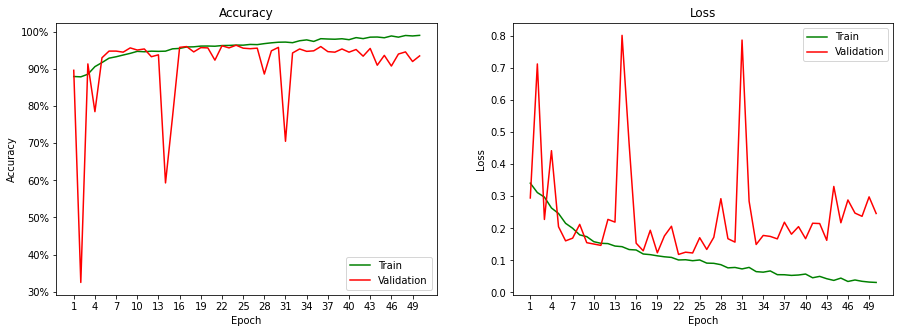

In [235]:
plotmodel(train_acc, valid_loss, train_loss, valid_acc,savedFigName='train_result.png')

In [0]:
# Confusion matrix
def plotcon(pred, test_label, savedFigName='confusion_matrix.png'):
  confusion_vecotr = pred / test_label
  true_positive = torch.sum(confusion_vector == 1).item()
  false_positive = torch.sum(confusion_vector == float('inf')).item()
  true_negative = torch.sum(torch.isnan(confusion_vector)).item()
  false_negative = torch.sum(confusion_vector == 0).item()
  con_mat = [[true_positive, false_positive], [false_negative, true_negative]]
  con_mat_df = pd.DataFrame(con_mat, index = [0, 1], columns = [0, 1]) # create a dataframe for plotting

  # Show confusion matrix
  figure = plt.figure(figsize=(10, 10))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues, fmt='g')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(savedFigName)
  plt.show()

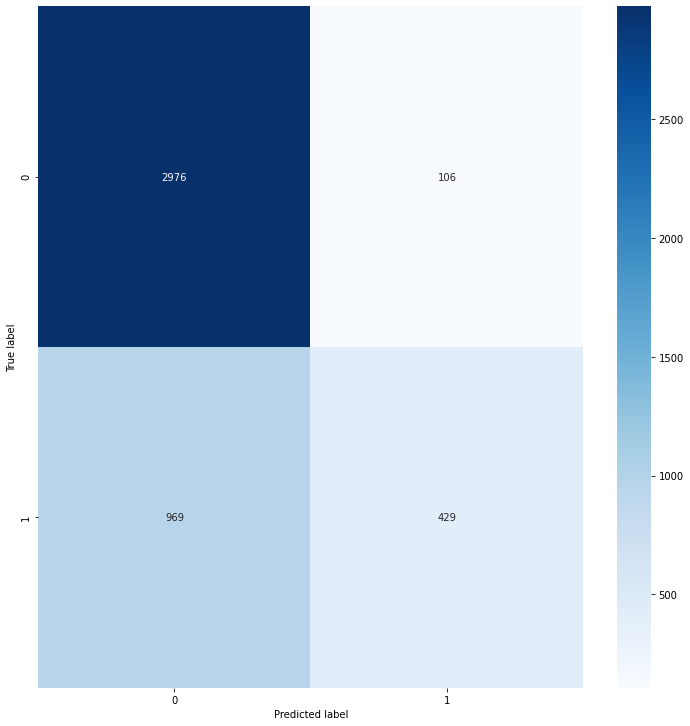

In [237]:
plotcon(pred, test_label, savedFigName='confusion_matrix.png')

In [0]:
# ROC Curve
def plotroc(prob, test_label, valid_label, valid_prob, savedFigName='roc_curve.png'):
  fpr, tpr, threshold = roc_curve(test_label, prob)

  fpr_val, tpr_val, threshold_val = roc_curve(valid_label, valid_prob)
  auc_result = auc(fpr, tpr)
  auc_result_val = auc(fpr_val, tpr_val)

  plt.figure(figsize=(10, 10))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Testing (AUC = {:.3f})'.format(auc_result))
  plt.plot(fpr_val, tpr_val, label='Validation (AUC = {:.3f})'.format(auc_result_val))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig(savedFigName)
  plt.show()

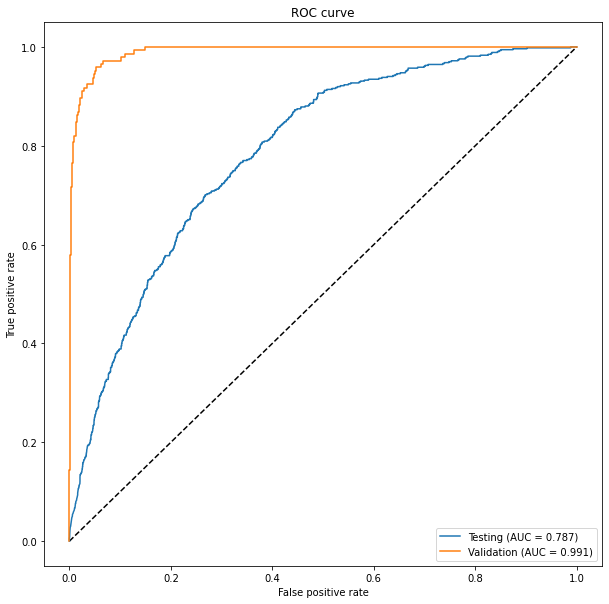

In [236]:
plotroc(prob, test_label, valid_label, valid_prob, savedFigName='roc_curve.png')